In [3]:
from qiskit import *
from qiskit.tools import visualization
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
from math import sqrt
import time
import networkx as nx
import matplotlib.pyplot as plt

# Read Graph

In [4]:
def read_graph(name):
    num_vertices = 0
    num_edges = 0 
    list_edges = []
    file = open("data/" + name , "r")
    for line in file:
        tokens = line.split()
        if(tokens[0] == "c"):
            #this line is a comment
            continue
        elif(tokens[0] == "p"and tokens[1] == "edge"):
            # save number of vertices and edges
            num_vertices = tokens[2]
            num_edges = tokens[3]
        else:
            # this is a line describing an edge
            temp = [int(tokens[1]), int(tokens[2])]
            list_edges.append(temp)
    file.close()
    return int(num_vertices), int(num_edges), list_edges

# Reduce to SAT

In [5]:
def reduce_to_SAT(nv, ne, ledges, k_colors):
    
    def get_vertex_color_repr(vertex):
        temp = list()
        for i in range (k_colors):
            temp.append(k_colors*vertex - i)
        return temp
    
    
    def get_vertex_contraints(vertex):
        constraints = []
        vertex_color_repr = get_vertex_color_repr(vertex)
        temp = []
        # select at least one color
        for c in vertex_color_repr: 
            #temp += str(c) + " "
            temp.append(c)
        
        #temp+="0"
        constraints.append(temp);
        
        #select at most one color
        for c1 in range(len(vertex_color_repr)):
            for c2 in range(c1+1, len(vertex_color_repr)):
                temp = []
                temp.append(-vertex_color_repr[c1])
                temp.append(-vertex_color_repr[c2])
                constraints.append(temp)
        return constraints
    
    
    def get_edge_constraints(v1, v2):
        constraints = []
        v1_color_repr = get_vertex_color_repr(v1)
        v2_color_repr = get_vertex_color_repr(v2)
        
        for i in range(len(v1_color_repr)):
            temp = []
            temp.append(-v1_color_repr[i])
            temp.append(-v2_color_repr[i])
            #constraints.append("-" + str(v1_color_repr[i]) + " -" + str(v2_color_repr[i]) + " 0")
            constraints.append(temp)
        return constraints
                
    buffer = []
    
    #buffer.append("p cnf " + str(nv*k_colors) + " " + str(ne*k_colors + nv*int(1 +( k_colors * (k_colors-1) )/2 ) ))
    num_variables = nv*k_colors
    for i in range(1, nv+1):
        buffer.extend(get_vertex_contraints(i))
    
    for e in ledges:
        buffer.extend(get_edge_constraints(e[0], e[1]))
    return buffer, num_variables

# Grover Algorithm Utils (Non-Standard Gates)

In [6]:
def n_controlled_X(circuit, controls, target, ancillas,n):
    if(len(controls) < 1):
        pass
    elif len(controls) == 1:
        circuit.cx(controls[0], target)
    elif len(controls) == 2:
        circuit.ccx(controls[0], controls[1], target)
    else:
        # compute
        circuit.ccx(controls[0], controls[1], ancillas[0])
        for i in range(2, n):
            circuit.ccx(controls[i], ancillas[i-2], ancillas[i-1])

        # copy
        circuit.cx(ancillas[n-2], target[0])

        # uncompute
        for i in range(n-1, 1, -1):
            circuit.ccx(controls[i], ancillas[i-2], ancillas[i-1])
        circuit.ccx(controls[0], controls[1], ancillas[0]) 

In [7]:
def n_controlled_Z(circuit, controls, target, ancillas):
    """Implement a Z gate with multiple controls"""
    #if (len(controls) > 2):
    #    raise ValueError('The controlled Z with more than 2 ' +
    #                     'controls is not implemented')
    n = len(controls)
    if(n == 0):
        circuit.h(target)
        circuit.x(target)
        circuit.h(target)
        circuit.x(target)
    elif (n == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (n == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
    else:
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], ancillas[0])
        for i in range(2, n):
            circuit.ccx(controls[i], ancillas[i-2], ancillas[i-1])
        # copy
        circuit.cx(ancillas[n-2], target[0])
        # uncompute
        for i in range(n-1, 1, -1):
            circuit.ccx(controls[i], ancillas[i-2], ancillas[i-1])
        circuit.ccx(controls[0], controls[1], ancillas[0]) 
        circuit.h(target)

# Grover Algorithm Steps

In [8]:
def initialize(circuit, q_in, y, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(q_in[j])
    circuit.x(y)
    circuit.h(y)

In [9]:
def oracle(circuit, q_in, q_out, aux, n, formula, ancillas=[]):
    num_clauses = len(formula)
    for (k, clause) in enumerate(formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        q_literals_in_clause = []
        for literal in clause:
            if literal > 0:
                q_literals_in_clause.append(q_in[literal-1])
                circuit.cx(q_in[literal-1], aux[k])
            else:
                q_literals_in_clause.append(q_in[-literal-1])
                circuit.x(q_in[-literal-1])
                circuit.cx(q_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        if len(q_literals_in_clause) > 1:
            n_controlled_X(circuit, q_literals_in_clause, aux[k], ancillas, len(q_literals_in_clause))
        for literal in clause:
            if literal < 0:
                circuit.x(q_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    n_controlled_X(circuit, aux, q_out, ancillas, num_clauses)
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        q_literals_in_clause = []
        for literal in clause:
            if literal > 0:
                q_literals_in_clause.append(q_in[literal-1])
                circuit.cx(q_in[literal-1], aux[k])
            else:
                q_literals_in_clause.append(q_in[-literal-1])
                circuit.x(q_in[-literal-1])
                circuit.cx(q_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        if len(q_literals_in_clause) > 1:
            n_controlled_X(circuit, q_literals_in_clause, aux[k], ancillas, len(q_literals_in_clause))
        for literal in clause:
            if literal < 0:
                circuit.x(q_in[-literal-1])

In [10]:
def inversion_about_average(circuit, q_in, n, ancillas):
    """Apply inversion about the average step of Grover's algorithm."""
    for j in range(n):
        circuit.h(q_in[j])
    for j in range(n):
        circuit.x(q_in[j])
    n_controlled_Z(circuit, [q_in[j] for j in range(n-1)], q_in[n-1], ancillas)
    for j in range(n):
        circuit.x(q_in[j])
    for j in range(n):
        circuit.h(q_in[j])

In [11]:
def make_reads(circuit, q_in, cr, n):
    for i in range(n):
        circuit.measure(q_in[i], cr[i])

In [12]:
def estimate_ancilla_usage(num_variables, clauses):
    return max(num_variables-2, len(clauses)-1)
    

In [13]:
def grover(clauses, num_variables, simulated,backend_name ='ibmq_16_melbourne', extra_iters = 0):
    circuit = QuantumCircuit()
    q_in = QuantumRegister(num_variables, "var")
    q_out = QuantumRegister(1, "y")
    aux = QuantumRegister(len(clauses), "c")
    ancillas = []
    if(estimate_ancilla_usage(num_variables, clauses) > 0):
        ancillas = QuantumRegister(estimate_ancilla_usage(num_variables, clauses), "a")
        circuit.add_register(ancillas)
    cr = ClassicalRegister(num_variables)
    circuit.add_register(q_in)
    circuit.add_register(q_out)
    circuit.add_register(aux)
    circuit.add_register(cr)
    initialize(circuit,q_in, q_out, num_variables)
    for i in range(int(sqrt(2**num_variables))+extra_iters):
        oracle(circuit, q_in, q_out, aux, num_variables, clauses, ancillas)
        inversion_about_average(circuit, q_in, num_variables, ancillas)
    make_reads(circuit, q_in, cr, num_variables)
    result = ""
    if simulated:
        start_time = time.time()
        result = execute(circuit, QasmSimulator(), shots=1024).result()
        elapsed_time = time.time() - start_time
    else:
        provider = IBMQ.load_account()
        backend = provider.get_backend(backend_name)
        start_time = time.time()
        result = execute(circuit, backend, shots=1024).result()
        elapsed_time = time.time() - start_time
    
    print("execution time: ", elapsed_time)

    return result

# Solving K-Coloring

In [14]:
def search_k_coloring(name, k, simulated=True, backend_name='ibmq_16_melbourne', extra_iters = 0):
    print("processing ", name, "... ")
    nv, ne, le = read_graph(name)
    clauses, num_variables = reduce_to_SAT(nv, ne, le, k)
    return grover(clauses, num_variables,simulated,backend_name=backend_name, extra_iters=extra_iters)

# Utils

In [15]:
def draw_graph(name,coloring = None):
    nv, ne, le = read_graph(name)
    G = nx.Graph()
    G.add_nodes_from([(i+1) for i in range(nv)])
    G.add_edges_from(le)
    if not (coloring == None):
        nx.draw_circular(G, with_labels=True, node_color=node_colors, node_size=3000)
    else:
        nx.draw_circular(G, with_labels=True, node_size=3000, cmap=plt.cm.rainbow)
    plt.show()

In [16]:
def getQubitNum(graph_name, k):
    nv, ne, le = read_graph(graph_name)
    clauses, num_variables = reduce_to_SAT(nv, ne, le, k)
    ans = num_variables + 1 + len(clauses) + estimate_ancilla_usage(num_variables, clauses)
    return ans

In [17]:
def getGateCount(graph_name, k):
    def xz_gate_count(len_controls):
        if len_controls < 3:
            return 3
        else:
            return  2*len_controls + 2
    def init_count(n):
        return n + 2
    
    def oracle_count(formula):
        ans  = 0
        for clause in formula:
            for literal in clause:
                if literal < 0:
                    ans+=2
                else:
                    ans+=1
                    
            if len(clause) > 1:
                ans+=xz_gate_count(len(clause))
            
            for literal in clause:
                if literal < 0:
                    ans+=1   
        ans*=2
        
        ans+=xz_gate_count(len(formula))
        
        return ans
    
    def inversion_count(n):
        return 2*n + xz_gate_count(n-1)
    
    def grover_count(clauses, num_variables):
        ans = init_count(num_variables) + oracle_count(clauses) + inversion_count(num_variables)
        return ans
            
    nv, ne, le = read_graph(graph_name)
    clauses, num_variables = reduce_to_SAT(nv, ne, le, k)
    gate_count = grover_count(clauses, num_variables)
    return gate_count

In [18]:
def is_coloring_valid(s, nv, le, k):
    map_colors = {}
    color = 0
    vertex_colors = []
    
    temp =""
    c = 0
    count_zeros = 0
    for i in range(len(s)-1, -1,-1):
        temp+= s[i]
        if(s[i] == '0'):
            count_zeros+=1
        c+=1
        if(c == k):
            
            if count_zeros == k:
                return False
            if k-1 != count_zeros :
                return False
    
            if temp in map_colors:
                vertex_colors.append(map_colors[temp])
            else:
                map_colors[temp] = color
                vertex_colors.append(color)
                color+=1
            c = 0
            temp = ""
            count_zeros = 0
    
    for e in le:
        if vertex_colors[e[0]-1] == vertex_colors[e[1]-1]:
            return False
    return True

In [19]:
def getAccuracy(k, counts, graph_name):
    nv, ne, le = read_graph(graph_name)
    ans = 0
    for s in counts:
        if is_coloring_valid(s, nv, le, k):
            ans+=counts[s]
    return ans/1024.0
    

# Test 0:

In [296]:
result = grover([[1, 2, -3], [-1, -2, -3], [-1, 2, 3]],3, True)

execution time:  0.1389460563659668


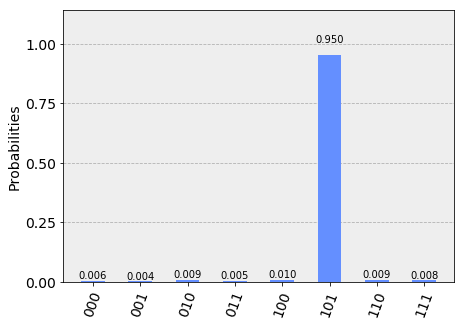

In [297]:
answer = result.get_counts()
plot_histogram(answer)

# Test 1

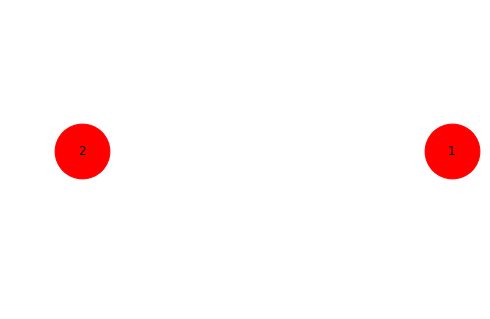

In [370]:
draw_graph('graph1.txt')

In [340]:
print("Qubit usage: " ,getQubitNum('graph1.txt',1))

Qubit usage:  6


In [391]:
print("Gate count: ", getGateCount('graph1.txt', 1))

Gate count:  18


### Quantum Computer Results 

processing  graph1.txt ... 
execution time:  578.6188752651215


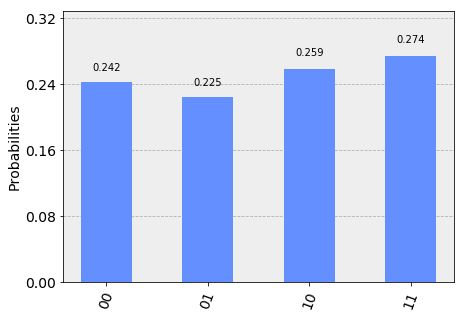

In [319]:
result= search_k_coloring("graph1.txt", 1, False, extra_iters=2) # +2
answer = result.get_counts()
plot_histogram(answer)

processing  graph1.txt ... 
execution time:  0.09783196449279785


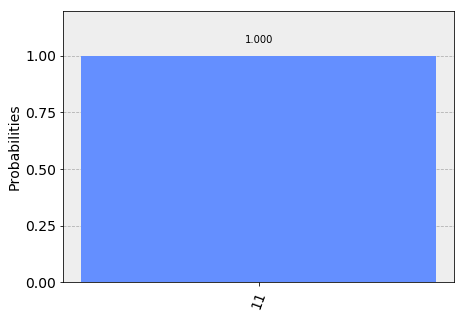

In [20]:
result= search_k_coloring("graph1.txt", 1, False, extra_iters=2) # +2
answer = result.get_counts()
plot_histogram(answer)

In [ ]:
getAccuracy(1, answer, "graph1.txt")

### Quantum Simulator Results

In [358]:
result= search_k_coloring("graph1.txt", 1, extra_iters=2) 
answer = result.get_counts()

processing  graph1.txt ... 
execution time:  0.09282612800598145


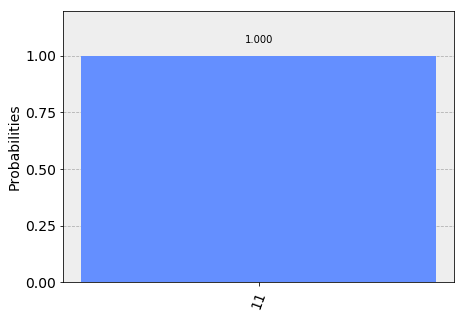

In [359]:
plot_histogram(answer)

# Test 2

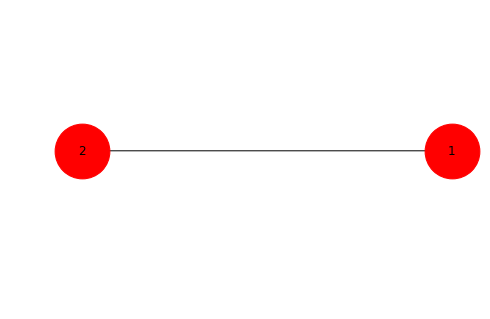

In [371]:
draw_graph('graph2.txt')

In [372]:
print("Qubit usage: " ,getQubitNum('graph2.txt',2))

Qubit usage:  16


In [392]:
print("Gate count: ", getGateCount('graph2.txt', 2))

Gate count:  128


processing  graph2.txt ... 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Accessing a bit register by bit[0] or its index by bit[1] is deprecated. Go for bit.register and bit.index.


execution time:  0.4106600284576416


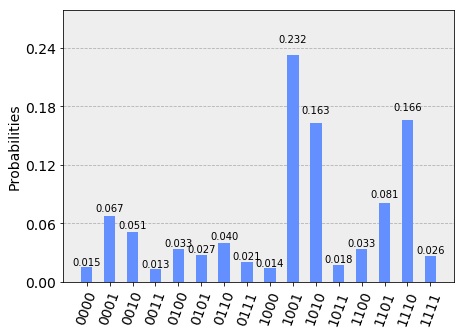

In [39]:
result = search_k_coloring("graph2.txt", 2, extra_iters=2)
answer = result.get_counts()
plot_histogram(answer)

In [45]:
getAccuracy(2, answer, "graph2.txt")

1000 False
0110 True
1011 False
1101 False
0010 False
1110 False
0001 False
0000 False
0100 False
1100 False
0101 False
1001 True
1111 False
1010 False
0111 False
0011 False


0.2724609375

In [265]:
maximum = max(answer, key=answer.get)  
print(maximum, answer[maximum])

1001 260


# Test 3

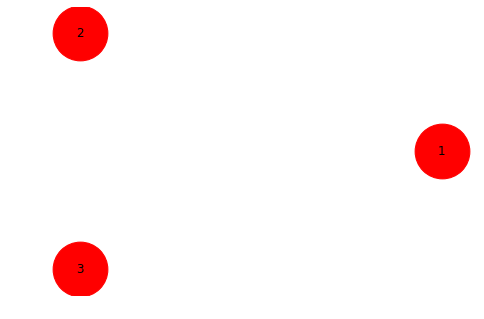

In [373]:
draw_graph('graph3.txt')

In [375]:
print("Qubit usage: " ,getQubitNum('graph3.txt',1))

Qubit usage:  9


In [395]:
print("Gate usage: " ,getGateCount('graph3.txt',1))

Gate usage:  28


## Quantum Results

In [ ]:
result= search_k_coloring("graph3.txt", 1, False, extra_iters=2) # +2
answer = result.get_counts()
plot_histogram(answer)

processing  graph3.txt ... 


/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '
Error checking job status using websocket, retrying using HTTP.


In [ ]:
getAccuracy(1, answer, "graph1.txt")

## Simulator Results

processing  graph3.txt ... 
execution time:  0.06365418434143066


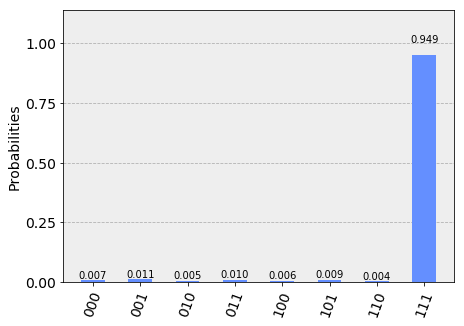

In [320]:
result = search_k_coloring("graph3.txt", 1)
answer = result.get_counts()
plot_histogram(answer)

processing  graph3.txt ... 
execution time:  0.6794078350067139


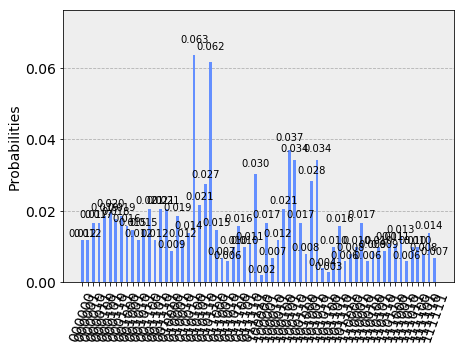

In [321]:
result = search_k_coloring("graph3.txt", 2)
answer = result.get_counts()
plot_histogram(answer)

In [161]:
maximum = max(answer, key=answer.get)
print(maximum, answer[maximum])

010101 85


# Test 4

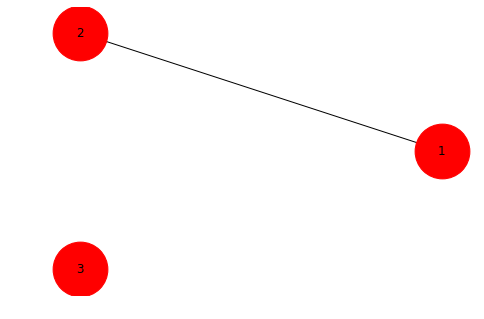

In [376]:
draw_graph('graph4.txt')

In [377]:
print("Qubit usage: " ,getQubitNum('graph4.txt',2))

Qubit usage:  22


In [396]:
print("Gate usage: " ,getGateCount('graph4.txt',2))

Gate usage:  170


num. ancillas:  (5, 7)
num. ancillas:  (5, 7)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Accessing a bit register by bit[0] or its index by bit[1] is deprecated. Go for bit.register and bit.index.


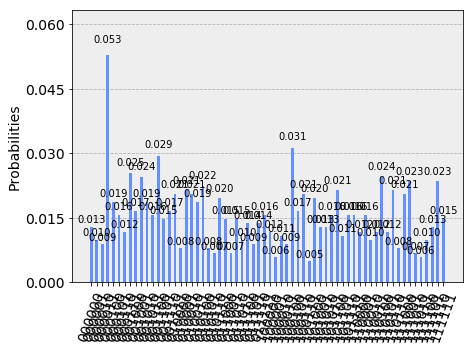

In [162]:
result = search_k_coloring("graph4.txt", 2)
answer = result.get_counts()
plot_histogram(answer)

In [116]:
maximum = max(answer, key=answer.get)
print(maximum, answer[maximum])

101001 41


processing  graph4.txt ... 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Accessing a bit register by bit[0] or its index by bit[1] is deprecated. Go for bit.register and bit.index.


execution time:  5.009613275527954


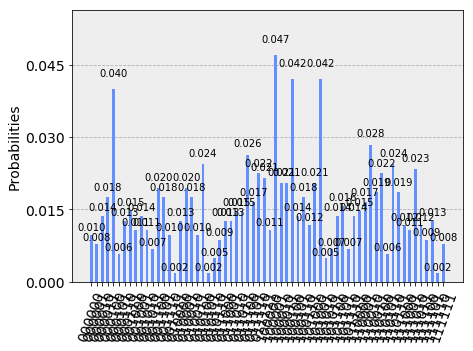

In [54]:
result = search_k_coloring("graph4.txt", 2)
answer = result.get_counts()
plot_histogram(answer)

In [55]:
getAccuracy(2, answer, "graph4.txt")

0.0771484375

# Test 5

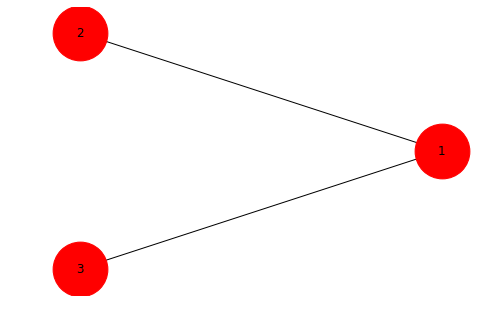

In [378]:
draw_graph('graph5.txt')

In [379]:
print("Qubit usage: " ,getQubitNum('graph5.txt',3))

Qubit usage:  45


In [397]:
print("Gate usage: " ,getGateCount('graph5.txt',3))

Gate usage:  421


# Test 6

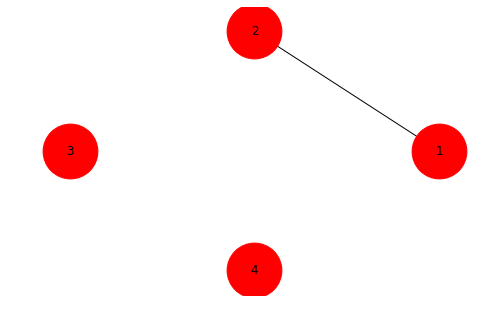

In [380]:
draw_graph('graph6.txt')

In [381]:
print("Qubit usage: " ,getQubitNum('graph6.txt',2))

Qubit usage:  28


In [398]:
print("Gate usage: " ,getGateCount('graph6.txt',2))

Gate usage:  212


# Test 7

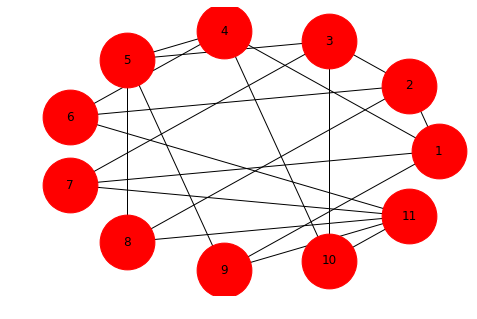

In [383]:
draw_graph('graph.txt')

In [385]:
print("Qubit usage: " ,getQubitNum('graph.txt',4))

Qubit usage:  358


In [399]:
print("Gate usage: " ,getGateCount('graph.txt',4))

Gate usage:  3474
